
# Sentiment Analysis
### Group 03:
- Catarina Oliveira | 20211616
- Daniel Kruk | 20211687
- Joana Rosa | 20211516
- Marcelo Junior | 20211677
- Martim Serra | 20211543

##### This notebook includes:
 - Sentiment Analysis of Song Lyrics

##### Table of contents:  
- Part 0: Imports
    - 0.1 Importing the Libraries
    - 0.2 Pre-processed Data Importation

- Part 1: Sentiment Analysis
    - 1.1 NRC Lexicon
    - 1.2 VADER and TextBlob Lexicons
    - 1.3 FLAIR Model

- Part 3: Insights Retrieval
    - 3.1 Insights Visualization
        - 3.1.1 WordClouds per Emotion
        - 3.1.2 WordClouds per Sentiment

### Part 0: Imports

#### 0.1: Library Imports

In [17]:
#For the functions to update automatically
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import preprocessing

#!pip install gensim
#!pip install flair
#!pip install nltk

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
from flair.nn import Classifier
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


#Importing our created functions 
from functions import *

from wordcloud import WordCloud

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 0.2: Pre-processed Data Importation

In [2]:
#replace by your path
data = pd.read_csv("C:\\Users\\danie\\Desktop\\after_preproc_data\\after_preproc_data\\train_preproc.csv", index_col= 'id').drop(columns='Unnamed: 0')


In [3]:
data.head()

,title,tag,artist,year,views,features,lyrics
id,,,,,,,
535805,walk away,rock,tony molina,2013,699,{},say love mean change mind one day pretend caus...
7519483,have got make it kid naruto rap,rap,reece lett,2021,4,{sl!ck},kid naruto rap hook everybody want hurt everyb...
4892808,​this is what i asked for,pop,elliot (dnk),2019,389,{},people tell change find hard explain maybe fee...
1584150,stealing hearts,pop,katie armiger,2013,126,{},warn try get close know want chain shall leave...
7639050,get ready,country,john campbell munro,1,2,{},see end come ive never like odds need way even...


In [4]:
unique_tags = data['tag'].unique().tolist()
unique_tags

['rock', 'rap', 'pop', 'country', 'rb', 'misc']

In [5]:
# See how many songs we have for each tag
data['tag'].value_counts()


tag
pop        55606
rap        38559
rock       25288
rb          6187
misc        5633
country     3461
Name: count, dtype: int64

### Part 1: Sentiment Analysis

For the sentiment analysis, 3 approaches were used:
- NRC Lexicon
- Vader
- TextBlob

Since the NRC Lexicon also provided some emotion analysis, it was found to be interesting to try an emotion analysis from the songs at hand.

#### 1.1: NRC Lexicon
NRC is a word emotion lexicon that provides a list of English words associated with 8 emotions: anger, anticipation, disgust, fear, joy, sadness, surprise, surprise and trust; as well as with 2 sentiments: negative and positive. 

In [6]:
#importing the lexicon
lexicon_path = "C:\\Users\\danie\\Desktop\\NRC_LEXICON\\NRC_LEXICON" #insert here your directory

# read all files in the folders
emotion_files = os.listdir(os.path.join(lexicon_path, 'Emotion'))
sentiment_files = os.listdir(os.path.join(lexicon_path, 'Sentiment'))

In [7]:
emotion_files

['anger.txt',
 'anticipation.txt',
 'disgust.txt',
 'fear.txt',
 'joy.txt',
 'sadness.txt',
 'surprise.txt',
 'trust.txt']

In [8]:
# create a dictionary with the lexicon considering each emotion
lexicon_emotion = {}
for file in emotion_files:
    with open(os.path.join(lexicon_path, 'Emotion', file), 'r') as f:
        for line in f:
            word, score = line.strip().split('\t')
            if word not in lexicon_emotion:
                lexicon_emotion[word] = {}
            lexicon_emotion[word][file.split('.')[0]] = float(score)

# create a dictionary with the lexicon considering each emotion
lexicon_sentiment = {}
for file in sentiment_files:
    with open(os.path.join(lexicon_path, 'Sentiment', file), 'r') as f:
        for line in f:
            word, score = line.strip().split('\t')
            if word not in lexicon_sentiment:
                lexicon_sentiment[word] = {}
            lexicon_sentiment[word][file.split('.')[0]] = float(score)

In [9]:
# each word has a score for each emotion and each sentiment
lexicon_emotion

{'idiotic': {'anger': 1.0,
  'anticipation': 0.0,
  'disgust': 1.0,
  'fear': 0.0,
  'joy': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'offend': {'anger': 1.0,
  'anticipation': 0.0,
  'disgust': 1.0,
  'fear': 0.0,
  'joy': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'strained': {'anger': 1.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'punishment': {'anger': 1.0,
  'anticipation': 0.0,
  'disgust': 1.0,
  'fear': 1.0,
  'joy': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'kicking': {'anger': 1.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'hardened': {'anger': 1.0,
  'anticipation': 0.0,
  'disgust': 1.0,
  'fear': 1.0,
  'joy': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'slaughter': {'anger': 1.0,
  'anticipation': 0.0,
  'disgust': 1.0,
  'fear': 1.0,
  'jo

 Now let's see how well can we find the emotion of a lyric. <br>
 We can use the lexicon instance created before. <br>
 We can do this be adding up the scores per emotion of each word in the lyric. <br>
 Then, we can set a threshold to decide if the lyric is of a certain emotion or not. <br>
 Remember that each word is a key in the dictionary, and the value has both a key (the emotion) and a value (the score). <br>

In [11]:
# Create a column with the lyrics split into words
data['lyric_words'] = data['lyrics'].apply(lambda x: x.split())

# Apply the function to each row in the DataFrame, keeping only the highest score
data['emotion_score'] = data.apply(lambda row: compute_emotion_score(row['lyric_words'], lexicon_emotion), axis=1)
data['sentiment_score'] = data.apply(lambda row: compute_emotion_score(row['lyric_words'], lexicon_sentiment), axis=1)

In [12]:
# We can store the emotion/sentiment with the highest score in two new columns
data['emotion'] = data['emotion_score'].apply(lambda x: max(x, key=x.get) if x else 'neutral')
data['sentiment'] = data['sentiment_score'].apply(lambda x: max(x, key=x.get) if x else 'neutral')

#### 1.2: Vader and TextBlob Lexicons

Vader (Valence Aware Dictionary and Sentiment Reasoning) allows the computation of the polarity based on the words used, meaning that the output will be a score of how negative, positive or neutral the text is. It is relevant to mention that it was trained on social media so it may be more accurate for informal text.

TextBlob is another lexicon that provides the polarity of each song. However, it is more accurate for formal text.

In [13]:
vader = SentimentIntensityAnalyzer()

In [14]:
scaler = preprocessing.MinMaxScaler()

#Applying vader and textblob to the data, scaled so that they can be compared
data["vader_song"] = data["lyrics"].apply(lambda song: vader_wrapper(song))
normalized_vader = scaler.fit_transform(data["vader_song"].to_numpy().reshape(-1, 1))
data["normalized_vader"] = normalized_vader.reshape(-1)

data["text_blob"] = data["lyrics"].apply(lambda song: textblob_wrapper(song))
normalized_textblob = scaler.fit_transform(data["text_blob"].to_numpy().reshape(-1, 1))
data["normalized_textblob"] = normalized_textblob.reshape(-1)

#### 1.3: Flair Model

Flair is a "state-of-the-art" NLP, which has a sentiment analysis model that uses distilBERT embeddings. It was trained on Amazon reviews. This specific version used in this project uses an RNN-based approach to increase the velocity of the model. It provides the polarity as positive or negative, and the confidence the model has on that score.

In [17]:
# load the model
tagger = Classifier.load('sentiment-fast')

In [ ]:
# create an empty column for flair scores
data['flair_confidence'] = None
data['flair_value'] = None

# iterate over the rows in the DataFrame with tqdm for progress bar
for index, row in tqdm(data.iterrows(), total=len(data), desc="Processing lyrics"):
    # create a Sentence object for the current lyric
    sentence = Sentence(row['lyrics'])

    # predict sentiment
    tagger.predict(sentence)

    # store the predicted sentiment score in the 'flair_score' column
    data.at[index, 'flair_confidence'] = sentence.labels[0].score
    data.at[index, 'flair_value'] = sentence.labels[0].value  # assuming only one label is predicted

Processing lyrics: 100%|██████████| 134461/134461 [32:47<00:00, 68.36it/s] 


In [ ]:
data

,year,views,title,tag,artist,features,lyrics,lyrics_lemma,POSTags,lyric_words,...,emotion,sentiment,vader_song,normalized_vader,text_blob,normalized_textblob,flair_score,normalized_flair,flair_confidence,flair_value
id,,,,,,,,,,,,,,,,,,,,,
535805,2013,699,walk away,rock,tony molina,{},say loved mean change mind pretend cause walk ...,"['say', 'loved', 'mean', 'change', 'mind', 'pr...","[('said', 'VBD'), ('loved', 'JJ'), ('mean', 'J...","[say, loved, mean, change, mind, pretend, caus...",...,fear,negative,0.7184,0.85920,0.193750,0.596875,0.971643,0.943285,0.971643,NEGATIVE
7519483,2021,4,gotta make it kid naruto rap,rap,reece lett,{sl!ck},naruto hook everybody want hurt everybody want...,"['naruto', 'hook', 'everybody', 'want', 'hurt'...","[('naruto', 'JJ'), ('hook', 'NN'), ('everybody...","[naruto, hook, everybody, want, hurt, everybod...",...,sadness,negative,-0.9882,0.00590,-0.083036,0.458482,0.999994,0.999989,0.999994,NEGATIVE
4892808,2019,389,​this is what i asked for,pop,elliot (dnk),{},people tell change find hard explain maybe fee...,"['people', 'tell', 'change', 'find', 'hard', '...","[('people', 'NNS'), ('tell', 'VBP'), ('changed...","[people, tell, change, find, hard, explain, ma...",...,anticipation,positive,0.4939,0.74695,0.262831,0.631415,0.867790,0.735574,0.86779,NEGATIVE
1584150,2013,126,stealing hearts,pop,katie armiger,{},warn close know want chain shall leave ghost t...,"['warn', 'close', 'know', 'want', 'chain', 'sh...","[('warned', 'VBN'), ('close', 'RB'), ('know', ...","[warn, close, know, want, chain, shall, leave,...",...,trust,negative,-0.9482,0.02590,0.058135,0.529067,0.999647,0.999295,0.999647,NEGATIVE
7639050,1,2,get ready,country,john campbell munro,{},come never like odds need even deal field arou...,"['come', 'never', 'like', 'odds', 'need', 'eve...","[('coming', 'VBG'), ('never', 'RB'), ('liked',...","[come, never, like, odds, need, even, deal, fi...",...,anticipation,positive,0.9868,0.99340,0.061905,0.530952,0.999032,0.998063,0.999032,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702980,2007,48,manhattan,pop,tijuana sweetheart,{},knew young would older many thing would tell c...,"['knew', 'young', 'would', 'older', 'many', 't...","[('knew', 'NN'), ('young', 'JJ'), ('would', 'M...","[knew, young, would, older, many, thing, would...",...,trust,positive,0.9826,0.99130,0.083333,0.541667,0.612652,0.225290,0.612652,NEGATIVE
4802970,2019,3593,belly shit,rap,lil gotit,"{""lil troup""}",intro gotit cash everything chrome future trou...,"['intro', 'gotit', 'cash', 'everything', 'chro...","[('intro', 'JJ'), ('gotit', 'NN'), ('cash', 'N...","[intro, gotit, cash, everything, chrome, futur...",...,anger,negative,-0.9991,0.00045,0.183172,0.591586,0.999697,0.999394,0.999697,NEGATIVE
403929,2014,301,the four loves,rock,heath mcnease,{},bear inside home young three boy fight daddy s...,"['bear', 'inside', 'home', 'young', 'three', '...","[('born', 'VBN'), ('inside', 'IN'), ('home', '...","[bear, inside, home, young, three, boy, fight,...",...,joy,positive,0.9829,0.99145,0.157917,0.578958,0.999453,0.998906,0.999453,POSITIVE


### Part 3: Insights Retrieval

#### 3.1: Insights Visualizations

In [20]:
data.describe()

,year,views,vader_song,normalized_vader,text_blob,normalized_textblob
count,134734.000000,1.347340e+05,134734.000000,134734.000000,134734.000000,134734.000000
mean,2009.465584,3.416276e+03,0.149273,0.574637,0.064855,0.532428
std,46.324213,4.195825e+04,0.856092,0.428046,0.185862,0.092931
min,1.000000,0.000000e+00,-1.000000,0.000000,-1.000000,0.000000
25%,2008.000000,2.200000e+01,-0.903300,0.048350,-0.046723,0.476638
50%,2015.000000,8.900000e+01,0.605550,0.802775,0.056019,0.528010
75%,2019.000000,4.730000e+02,0.970500,0.985250,0.173185,0.586593
max,2024.000000,3.604497e+06,1.000000,1.000000,1.000000,1.000000


With MinMax Scalling:
0 - negative;
0.5 - neutral;
1- positive;

Interesting details:
- The normalized median in vader is quite positive (0.89) which means that Vader is classifying a lot of songs has positive.
- The normalized median in textblob is around 0.53, so it is classiying lots of songs as neutral. 

Either way the three have min and max (normalized) of 0 and 1, meaning they have classified some songs as very negative and very positive.

It's also possible to see that flair score has quite a high mean and median, which means that the model is quite confident on its results.


In [ ]:
data[data['sentiment'] != data['flair_value'].str.lower()]

,year,views,title,tag,artist,features,lyrics,lyrics_lemma,POSTags,lyric_words,...,emotion,sentiment,vader_song,normalized_vader,text_blob,normalized_textblob,flair_score,normalized_flair,flair_confidence,flair_value
id,,,,,,,,,,,,,,,,,,,,,
4892808,2019,389,​this is what i asked for,pop,elliot (dnk),{},people tell change find hard explain maybe fee...,"['people', 'tell', 'change', 'find', 'hard', '...","[('people', 'NNS'), ('tell', 'VBP'), ('changed...","[people, tell, change, find, hard, explain, ma...",...,anticipation,positive,0.4939,0.74695,0.262831,0.631415,0.867790,0.735574,0.86779,NEGATIVE
2276689,2015,61,right there,rap,houstonblake,{},yeah yeah yeah yeah yeah right swear anit neve...,"['yeah', 'yeah', 'yeah', 'yeah', 'yeah', 'righ...","[('yeah', 'NN'), ('yeah', 'NN'), ('yeah', 'NN'...","[yeah, yeah, yeah, yeah, yeah, right, swear, a...",...,trust,positive,0.9946,0.99730,0.057143,0.528571,0.814347,0.628688,0.814347,NEGATIVE
7749704,2018,1,king cap,rap,yrm bear,"{""corey j.""}",bear slide curb like toosie homegirl make movi...,"['bear', 'slide', 'curb', 'like', 'toosie', 'h...","[('bear', 'JJ'), ('slide', 'NN'), ('curb', 'NN...","[bear, slide, curb, like, toosie, homegirl, ma...",...,trust,positive,0.5848,0.79240,-0.054309,0.472845,0.999927,0.999855,0.999927,NEGATIVE
665689,2015,28,you can hold,rap,taj ahkel,"{""kota the friend""}",eye lock call hold sight line vision want ligh...,"['eye', 'lock', 'call', 'hold', 'sight', 'line...","[('eyes', 'NNS'), ('locked', 'VBD'), ('call', ...","[eye, lock, call, hold, sight, line, vision, w...",...,joy,positive,0.9600,0.98000,0.034615,0.517308,0.852074,0.704143,0.852074,NEGATIVE
6523416,2021,1858,alameda,pop,lewis del mar,{},never fall line outskirt alameda thizzing glow...,"['never', 'fall', 'line', 'outskirt', 'alameda...","[('never', 'RB'), ('falling', 'VBG'), ('line',...","[never, fall, line, outskirt, alameda, thizzin...",...,sadness,negative,0.6637,0.83185,0.045578,0.522789,0.992337,0.984674,0.992337,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207490,2005,927,i am me,pop,ashlee simpson,{},fill space leave wake every night scent regret...,"['fill', 'space', 'leave', 'wake', 'every', 'n...","[('fill', 'NN'), ('spaces', 'NNS'), ('left', '...","[fill, space, leave, wake, every, night, scent...",...,fear,positive,0.7430,0.87150,-0.050000,0.475000,0.990104,0.980209,0.990104,NEGATIVE
7230511,2020,181,take a ride with a dumper,rap,tpseastsidewill & chanelle,"{""chanelle phaydrain""}",take ride dumper baby show live baby take ride...,"['take', 'ride', 'dumper', 'baby', 'show', 'li...","[('take', 'VB'), ('ride', 'NN'), ('dumper', 'I...","[take, ride, dumper, baby, show, live, baby, t...",...,joy,positive,-0.9674,0.01630,0.109166,0.554583,0.998791,0.997582,0.998791,NEGATIVE
979437,2002,136,crazy for leaving you,pop,a1 (band),{},crazy crazy thing hear never really crime go a...,"['crazy', 'crazy', 'thing', 'hear', 'never', '...","[('crazy', 'JJ'), ('crazy', 'JJ'), ('things', ...","[crazy, crazy, thing, hear, never, really, cri...",...,sadness,negative,-0.9768,0.01160,-0.343651,0.328175,0.998064,0.996128,0.998064,POSITIVE


In [ ]:
data[(data['sentiment'] == 'positive') & (data['vader_song'] > 0)] #53 860 rows considered different results between nrc and vader

,year,views,title,tag,artist,features,lyrics,lyrics_lemma,POSTags,lyric_words,...,sentiment_score,emotion,sentiment,vader_song,normalized_vader,text_blob,normalized_textblob,flair_score,flair_confidence,flair_value
id,,,,,,,,,,,,,,,,,,,,,
4892808,2019,389,​this is what i asked for,pop,elliot (dnk),{},people tell change find hard explain maybe fee...,"['people', 'tell', 'change', 'find', 'hard', '...","[('people', 'NNS'), ('tell', 'VBP'), ('changed...","[people, tell, change, find, hard, explain, ma...",...,"{'negative': 3.0, 'positive': 5.0}",anticipation,positive,0.4939,0.74695,0.262831,0.631415,0.867790,0.86779,NEGATIVE
7639050,1,2,get ready,country,john campbell munro,{},come never like odds need even deal field arou...,"['come', 'never', 'like', 'odds', 'need', 'eve...","[('coming', 'VBG'), ('never', 'RB'), ('liked',...","[come, never, like, odds, need, even, deal, fi...",...,"{'negative': 8.0, 'positive': 12.0}",anticipation,positive,0.9868,0.99340,0.061905,0.530952,0.999032,0.999032,POSITIVE
2276689,2015,61,right there,rap,houstonblake,{},yeah yeah yeah yeah yeah right swear anit neve...,"['yeah', 'yeah', 'yeah', 'yeah', 'yeah', 'righ...","[('yeah', 'NN'), ('yeah', 'NN'), ('yeah', 'NN'...","[yeah, yeah, yeah, yeah, yeah, right, swear, a...",...,"{'negative': 3.0, 'positive': 17.0}",trust,positive,0.9946,0.99730,0.057143,0.528571,0.814347,0.814347,NEGATIVE
7749704,2018,1,king cap,rap,yrm bear,"{""corey j.""}",bear slide curb like toosie homegirl make movi...,"['bear', 'slide', 'curb', 'like', 'toosie', 'h...","[('bear', 'JJ'), ('slide', 'NN'), ('curb', 'NN...","[bear, slide, curb, like, toosie, homegirl, ma...",...,"{'negative': 24.0, 'positive': 29.0}",trust,positive,0.5848,0.79240,-0.054309,0.472845,0.999927,0.999927,NEGATIVE
5659885,1984,19,old friend,pop,tom robinson,{},day remember day come year slip soquickly noww...,"['day', 'remember', 'day', 'come', 'year', 'sl...","[('days', 'NNS'), ('remember', 'VBP'), ('days'...","[day, remember, day, come, year, slip, soquick...",...,"{'negative': 8.0, 'positive': 12.0}",joy,positive,0.9868,0.99340,0.134091,0.567045,0.998499,0.998499,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224341,2013,93,love is war,rap,cashus king,{},uhhh love love lover lover retreat three inch ...,"['uhhh', 'love', 'love', 'lover', 'lover', 're...","[('uhhh', 'JJ'), ('loves', 'VBZ'), ('loves', '...","[uhhh, love, love, lover, lover, retreat, thre...",...,"{'negative': 33.0, 'positive': 38.0}",joy,positive,0.9969,0.99845,0.080424,0.540212,0.999358,0.999358,POSITIVE
1756600,1993,1564,born toulouse-lautrec,rock,new bomb turks,{},friend say artist knew average schmuck say mus...,"['friend', 'say', 'artist', 'knew', 'average',...","[('friend', 'NN'), ('said', 'VBD'), ('artist',...","[friend, say, artist, knew, average, schmuck, ...",...,"{'negative': 3.0, 'positive': 20.0}",trust,positive,0.9898,0.99490,0.006385,0.503193,0.645258,0.645258,POSITIVE
5283239,2019,162,transform,pop,julianne hough,{},ooooohhh ooooohhh beauty feel ugly sometimes w...,"['ooooohhh', 'ooooohhh', 'beauty', 'feel', 'ug...","[('ooooohhh', 'JJ'), ('ooooohhh', 'MD'), ('bea...","[ooooohhh, ooooohhh, beauty, feel, ugly, somet...",...,"{'negative': 10.0, 'positive': 18.0}",fear,positive,0.9842,0.99210,-0.125000,0.437500,0.999600,0.9996,POSITIVE


In [ ]:
data[(data['flair_value'].str.lower() == 'positive') & (data['vader_song'] > 0)] #44641 rows considered different results between nrc and vader

,year,views,title,tag,artist,features,lyrics,lyrics_lemma,POSTags,lyric_words,...,sentiment_score,emotion,sentiment,vader_song,normalized_vader,text_blob,normalized_textblob,flair_score,flair_confidence,flair_value
id,,,,,,,,,,,,,,,,,,,,,
7639050,1,2,get ready,country,john campbell munro,{},come never like odds need even deal field arou...,"['come', 'never', 'like', 'odds', 'need', 'eve...","[('coming', 'VBG'), ('never', 'RB'), ('liked',...","[come, never, like, odds, need, even, deal, fi...",...,"{'negative': 8.0, 'positive': 12.0}",anticipation,positive,0.9868,0.99340,0.061905,0.530952,0.999032,0.999032,POSITIVE
5659885,1984,19,old friend,pop,tom robinson,{},day remember day come year slip soquickly noww...,"['day', 'remember', 'day', 'come', 'year', 'sl...","[('days', 'NNS'), ('remember', 'VBP'), ('days'...","[day, remember, day, come, year, slip, soquick...",...,"{'negative': 8.0, 'positive': 12.0}",joy,positive,0.9868,0.99340,0.134091,0.567045,0.998499,0.998499,POSITIVE
6523416,2021,1858,alameda,pop,lewis del mar,{},never fall line outskirt alameda thizzing glow...,"['never', 'fall', 'line', 'outskirt', 'alameda...","[('never', 'RB'), ('falling', 'VBG'), ('line',...","[never, fall, line, outskirt, alameda, thizzin...",...,"{'negative': 7.0, 'positive': 3.0}",sadness,negative,0.6637,0.83185,0.045578,0.522789,0.992337,0.992337,POSITIVE
3822845,2016,44,what do you really want from me,pop,young diamond,{},sing couple song whole world money pussy every...,"['sing', 'couple', 'song', 'whole', 'world', '...","[('sing', 'VBG'), ('couple', 'NN'), ('songs', ...","[sing, couple, song, whole, world, money, puss...",...,"{'negative': 22.0, 'positive': 32.0}",joy,positive,0.6144,0.80720,-0.098485,0.450758,0.985260,0.98526,POSITIVE
782091,2009,1022,hey baby acoustic,pop,stephen marley,{},baby dont worry even though road rocky come ho...,"['baby', 'dont', 'worry', 'even', 'though', 'r...","[('baby', 'NN'), ('dont', 'NN'), ('worry', 'NN...","[baby, dont, worry, even, though, road, rocky,...",...,"{'negative': 20.0, 'positive': 25.0}",anticipation,positive,0.9963,0.99815,0.225123,0.612561,0.999822,0.999822,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644001,1984,4753,heartbeat,pop,wham!,{},another summer another vacation september smel...,"['another', 'summer', 'another', 'vacation', '...","[('another', 'DT'), ('summer', 'NN'), ('anothe...","[another, summer, another, vacation, september...",...,"{'negative': 12.0, 'positive': 21.0}",joy,positive,0.9948,0.99740,0.125962,0.562981,0.999796,0.999796,POSITIVE
224341,2013,93,love is war,rap,cashus king,{},uhhh love love lover lover retreat three inch ...,"['uhhh', 'love', 'love', 'lover', 'lover', 're...","[('uhhh', 'JJ'), ('loves', 'VBZ'), ('loves', '...","[uhhh, love, love, lover, lover, retreat, thre...",...,"{'negative': 33.0, 'positive': 38.0}",joy,positive,0.9969,0.99845,0.080424,0.540212,0.999358,0.999358,POSITIVE
1756600,1993,1564,born toulouse-lautrec,rock,new bomb turks,{},friend say artist knew average schmuck say mus...,"['friend', 'say', 'artist', 'knew', 'average',...","[('friend', 'NN'), ('said', 'VBD'), ('artist',...","[friend, say, artist, knew, average, schmuck, ...",...,"{'negative': 3.0, 'positive': 20.0}",trust,positive,0.9898,0.99490,0.006385,0.503193,0.645258,0.645258,POSITIVE


In [ ]:
data[(data['flair_value'].str.lower() == 'positive') & (data['text_blob'] > 0)] #46641 rows considered different results between nrc and vader

,year,views,title,tag,artist,features,lyrics,lyrics_lemma,POSTags,lyric_words,...,sentiment_score,emotion,sentiment,vader_song,normalized_vader,text_blob,normalized_textblob,flair_score,flair_confidence,flair_value
id,,,,,,,,,,,,,,,,,,,,,
7639050,1,2,get ready,country,john campbell munro,{},come never like odds need even deal field arou...,"['come', 'never', 'like', 'odds', 'need', 'eve...","[('coming', 'VBG'), ('never', 'RB'), ('liked',...","[come, never, like, odds, need, even, deal, fi...",...,"{'negative': 8.0, 'positive': 12.0}",anticipation,positive,0.9868,0.99340,0.061905,0.530952,0.999032,0.999032,POSITIVE
5659885,1984,19,old friend,pop,tom robinson,{},day remember day come year slip soquickly noww...,"['day', 'remember', 'day', 'come', 'year', 'sl...","[('days', 'NNS'), ('remember', 'VBP'), ('days'...","[day, remember, day, come, year, slip, soquick...",...,"{'negative': 8.0, 'positive': 12.0}",joy,positive,0.9868,0.99340,0.134091,0.567045,0.998499,0.998499,POSITIVE
6523416,2021,1858,alameda,pop,lewis del mar,{},never fall line outskirt alameda thizzing glow...,"['never', 'fall', 'line', 'outskirt', 'alameda...","[('never', 'RB'), ('falling', 'VBG'), ('line',...","[never, fall, line, outskirt, alameda, thizzin...",...,"{'negative': 7.0, 'positive': 3.0}",sadness,negative,0.6637,0.83185,0.045578,0.522789,0.992337,0.992337,POSITIVE
2235574,2015,34,good thing - skacoustic,pop,reel big fish,{},never felt good world would always thinkin som...,"['never', 'felt', 'good', 'world', 'would', 'a...","[('never', 'RB'), ('felt', 'VBD'), ('good', 'J...","[never, felt, good, world, would, always, thin...",...,"{'negative': 2.0, 'positive': 12.0}",trust,positive,-0.9029,0.04855,0.288663,0.644332,0.999556,0.999556,POSITIVE
782091,2009,1022,hey baby acoustic,pop,stephen marley,{},baby dont worry even though road rocky come ho...,"['baby', 'dont', 'worry', 'even', 'though', 'r...","[('baby', 'NN'), ('dont', 'NN'), ('worry', 'NN...","[baby, dont, worry, even, though, road, rocky,...",...,"{'negative': 20.0, 'positive': 25.0}",anticipation,positive,0.9963,0.99815,0.225123,0.612561,0.999822,0.999822,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4949509,2019,34,adore,pop,flunkie,{},everyone want nobody want know everyone adore ...,"['everyone', 'want', 'nobody', 'want', 'know',...","[('everyone', 'NN'), ('wants', 'VBZ'), ('nobod...","[everyone, want, nobody, want, know, everyone,...",...,"{'negative': 4.0, 'positive': 12.0}",joy,positive,0.9927,0.99635,0.166667,0.583333,0.999476,0.999476,POSITIVE
1644001,1984,4753,heartbeat,pop,wham!,{},another summer another vacation september smel...,"['another', 'summer', 'another', 'vacation', '...","[('another', 'DT'), ('summer', 'NN'), ('anothe...","[another, summer, another, vacation, september...",...,"{'negative': 12.0, 'positive': 21.0}",joy,positive,0.9948,0.99740,0.125962,0.562981,0.999796,0.999796,POSITIVE
224341,2013,93,love is war,rap,cashus king,{},uhhh love love lover lover retreat three inch ...,"['uhhh', 'love', 'love', 'lover', 'lover', 're...","[('uhhh', 'JJ'), ('loves', 'VBZ'), ('loves', '...","[uhhh, love, love, lover, lover, retreat, thre...",...,"{'negative': 33.0, 'positive': 38.0}",joy,positive,0.9969,0.99845,0.080424,0.540212,0.999358,0.999358,POSITIVE


In [ ]:
# Let's see the emotions sorted by frequency in each genre
data.groupby('tag')['emotion'].value_counts()

tag      emotion     
country  joy              1029
         anticipation      856
         trust             491
         sadness           408
         fear              326
         anger             157
         surprise          118
         disgust            73
misc     trust            2003
         anticipation     1087
         joy               767
         fear              731
         anger             447
         sadness           406
         disgust            96
         surprise           81
pop      joy             14077
         anticipation    12727
         trust            7305
         fear             7238
         sadness          6267
         anger            4615
         surprise         1926
         disgust          1300
         neutral            13
rap      anger           11501
         trust            6319
         fear             6125
         anticipation     5408
         joy              4111
         sadness          2639
         disgust 

In [ ]:
data.groupby('tag')['sentiment'].value_counts(normalize=True).mul(100)


tag      sentiment
country  positive     61.509543
         negative     38.490457
misc     positive     65.040940
         negative     34.959060
pop      positive     54.663950
         negative     45.312613
         neutral       0.023437
rap      negative     61.930239
         positive     38.064566
         neutral       0.005194
rb       positive     63.133193
         negative     36.850623
         neutral       0.016184
rock     negative     59.266891
         positive     40.713295
         neutral       0.019814
Name: proportion, dtype: float64

In [ ]:
data.groupby('tag')['flair_value'].value_counts(normalize=True).mul(100)

tag      flair_value
country  POSITIVE       61.885483
         NEGATIVE       38.114517
misc     POSITIVE       60.946956
         NEGATIVE       39.053044
pop      POSITIVE       56.762458
         NEGATIVE       43.237542
rap      NEGATIVE       74.355245
         POSITIVE       25.644755
rb       POSITIVE       52.548956
         NEGATIVE       47.451044
rock     POSITIVE       52.383594
         NEGATIVE       47.616406
Name: proportion, dtype: float64

In [ ]:
data.groupby('tag')['normalized_vader'].mean()


tag
country    0.751560
misc       0.696927
pop        0.671840
rap        0.456026
rb         0.740480
rock       0.532571
Name: normalized_vader, dtype: float64

In [ ]:
data.groupby('tag')['normalized_textblob'].mean()


tag
country    0.563469
misc       0.544593
pop        0.551156
rap        0.506220
rb         0.561408
rock       0.522194
Name: normalized_textblob, dtype: float64

In [ ]:
correlation_matrix = data[['normalized_vader', 'normalized_textblob']].corr() #0.48, not great correlation between both vader and textblob
print(correlation_matrix)

                     normalized_vader  normalized_textblob
normalized_vader             1.000000             0.479759
normalized_textblob          0.479759             1.000000


In [ ]:
contingency_table = pd.crosstab(data['sentiment'], data['flair_value'].str.lower())

# Display the contingency table
print(contingency_table)


flair_value  negative  positive
sentiment                      
negative        43915     25592
neutral            11        10
positive        27146     37787


In [ ]:
data['tag'].unique()


array(['rock', 'rap', 'pop', 'country', 'rb', 'misc'], dtype=object)

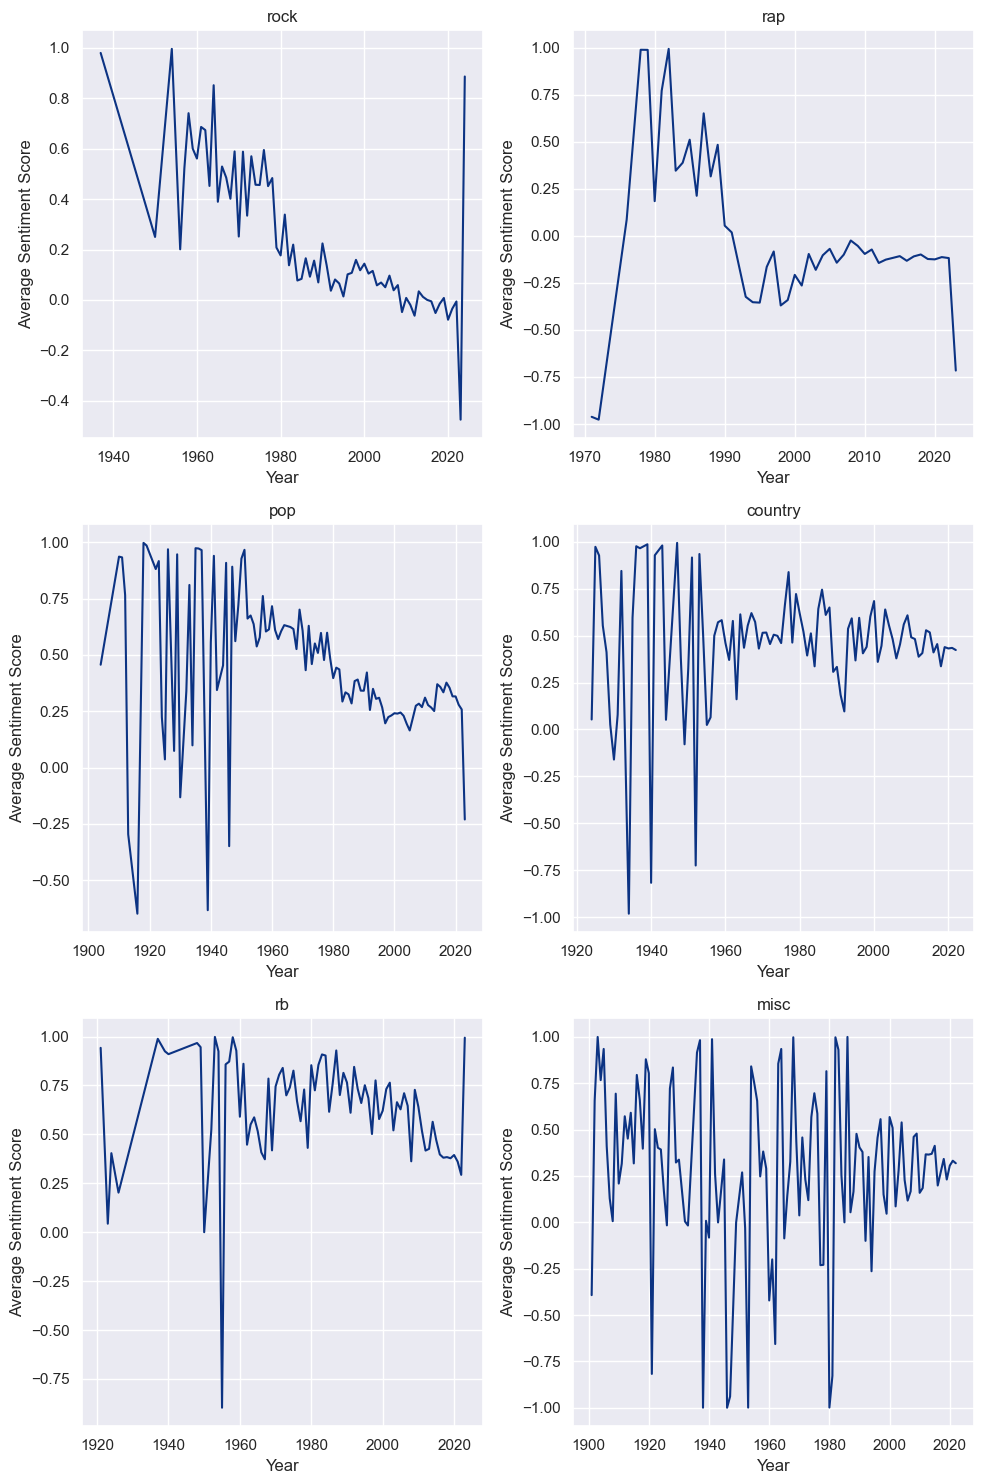

In [56]:
# most musics are from later than 1900, as one can see in data.describe() above, so it might be more interesting to see results after that year
data_1900 = data[data.year > 1900]
tags = data_1900['tag'].unique()

# Create a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))  # Adjust size here

for i, tag in enumerate(tags):
    row = i // 2
    col = i % 2
    df_tag = data_1900[data_1900['tag'] == tag]
    df_yearly = df_tag.groupby('year')['vader_song'].mean()  # Calculate mean on df_tag

    # Plotting
    axs[row, col].plot(df_yearly.index, df_yearly.values, color='#0c3383')
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Average Sentiment Score')
    axs[row, col].set_title(f'{tag}')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
data_1900.describe()

,year,views,vader_song,normalized_vader,text_blob,normalized_textblob,flair_score
count,133803.000000,1.338030e+05,133803.000000,133803.000000,133803.000000,133803.000000,133803.000000
mean,2011.263133,3.416681e+03,0.177839,0.588920,0.066550,0.533275,0.930121
std,12.634049,4.187658e+04,0.845075,0.422538,0.195115,0.097558,0.120436
min,1901.000000,0.000000e+00,-1.000000,0.000000,-1.000000,0.000000,0.500009
25%,2008.000000,2.200000e+01,-0.872900,0.063550,-0.050222,0.474889,0.921090
50%,2015.000000,9.000000e+01,0.654000,0.827000,0.057083,0.528542,0.993366
75%,2019.000000,4.750000e+02,0.970100,0.985050,0.183582,0.591791,0.999375
max,2024.000000,3.604497e+06,1.000000,1.000000,1.000000,1.000000,1.000000


c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

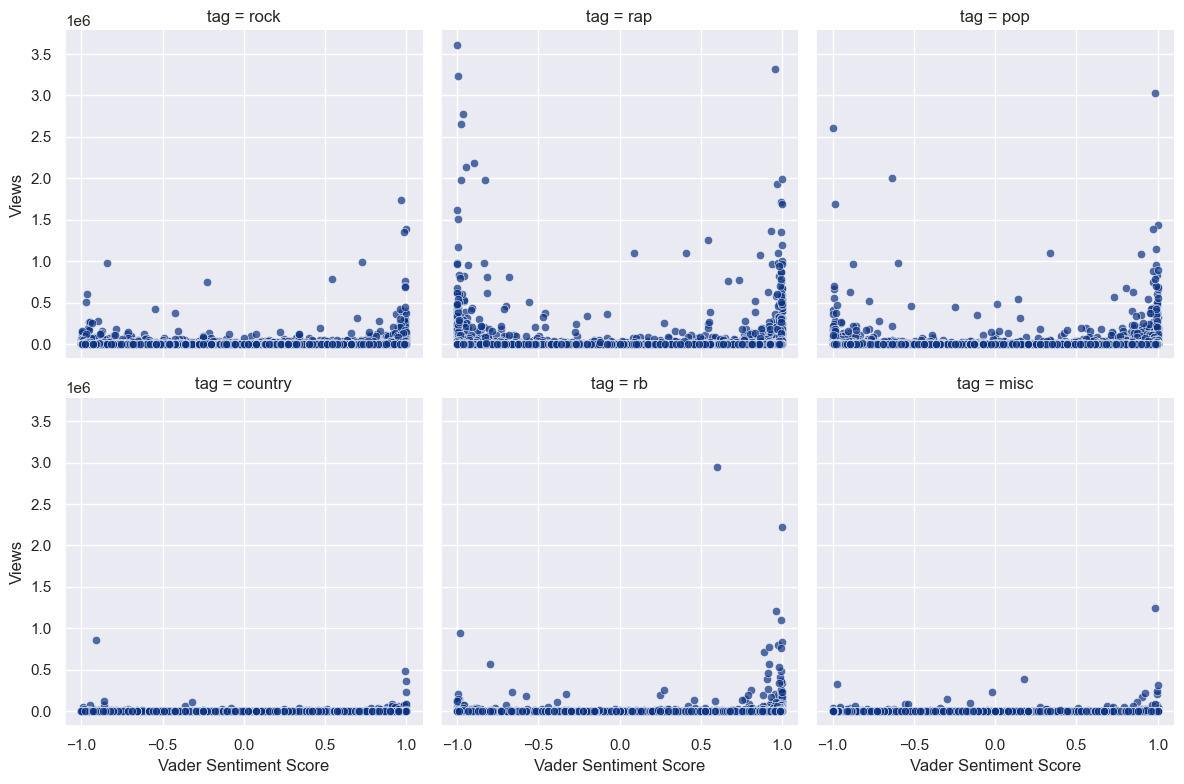

In [57]:
# Check if the sentiment might be correlated with the views
tags = data['tag'].unique()

# Create a FacetGrid with scatter plots for each genre
g = sns.FacetGrid(data, col="tag", col_wrap=3, height=4)
g.map(sns.scatterplot, 'vader_song', 'views', alpha=0.7, color='#0c3383')
g.set_axis_labels("Vader Sentiment Score", "Views")

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
#Aggregate Views and Sentiment Scores
aggreg_views_n_sents = data.groupby(['tag', 'artist']).agg({'views': 'sum', 'vader_song': 'mean',  'emotion': lambda x: x.mode()[0], 'flair_value': lambda x: x.mode()[0]}).reset_index()

#Identify Top Artists in Each Tag based on Summed Views
best_artists_per_tag = aggreg_views_n_sents.groupby('tag').apply(lambda x: x.nlargest(1, 'views')).reset_index(drop=True)

In [ ]:
best_artists_per_tag

,tag,artist,views,vader_song,emotion,flair_value
0,country,taylor swift,1196209,0.726608,joy,POSITIVE
1,misc,genius,1347735,0.924767,joy,POSITIVE
2,pop,taylor swift,3649837,0.769389,joy,NEGATIVE
3,rap,drake,10437349,0.242992,joy,NEGATIVE
4,rb,drake,4101669,0.942433,joy,POSITIVE
5,rock,led zeppelin,1816523,0.903200,joy,POSITIVE


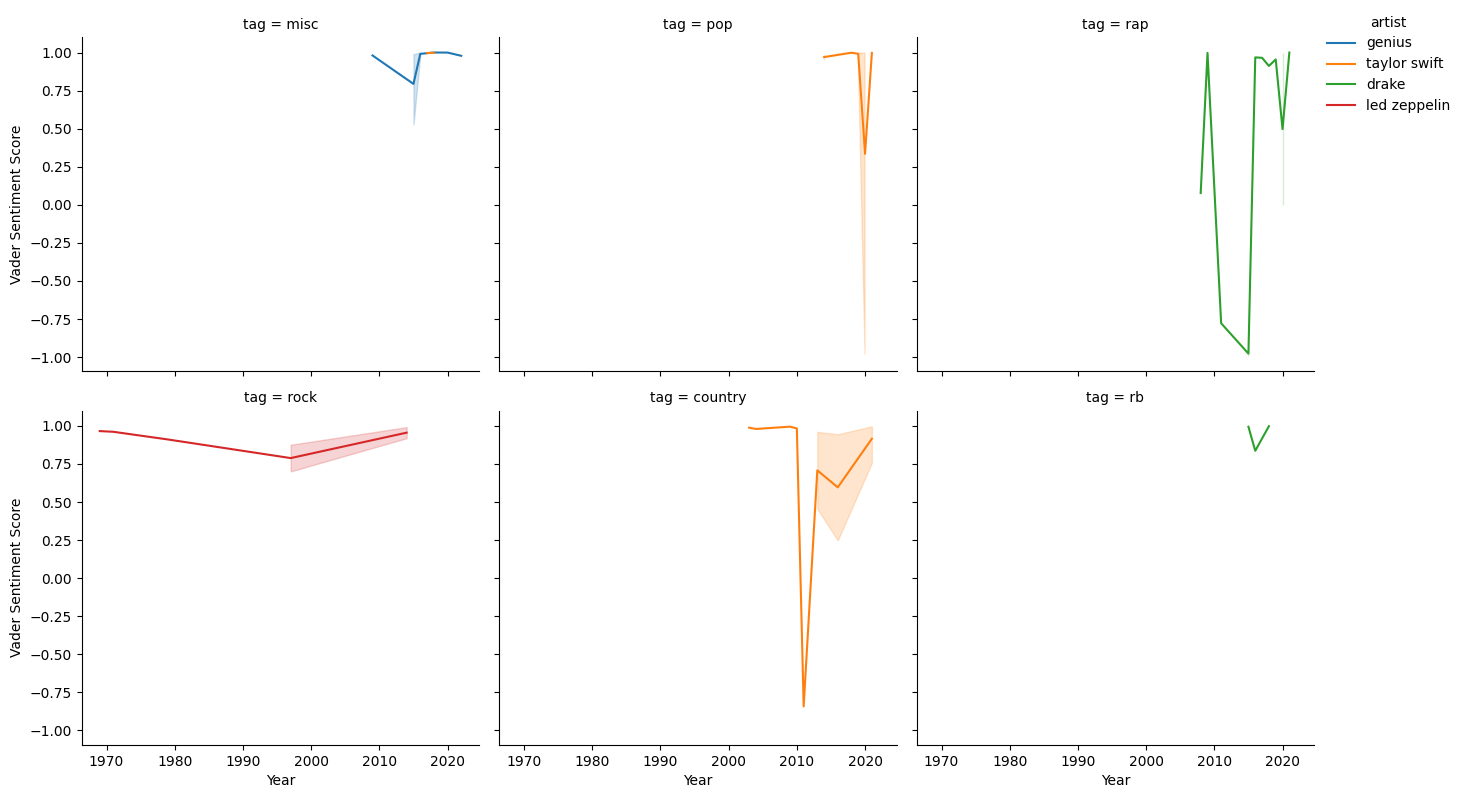

In [ ]:
# Top Artists in Each Tag based on Summed Views
top_artists_by_tag = data.groupby(['tag', 'artist']).agg({'views': 'sum'}).reset_index()
top_artists_by_tag = top_artists_by_tag.groupby('tag').apply(lambda x: x.nlargest(1, 'views')).reset_index(drop=True)

# Filter Data for Top Artists
filtered_data = data[data['artist'].isin(top_artists_by_tag['artist'])]

# Time Series Plot with Facet Grid
g = sns.FacetGrid(filtered_data, col="tag", hue="artist", col_wrap=3, height=4)
g.map(sns.lineplot, 'year', 'vader_song')
g.set_axis_labels("Year", "Vader Sentiment Score")
g.add_legend(loc = 'upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()


c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

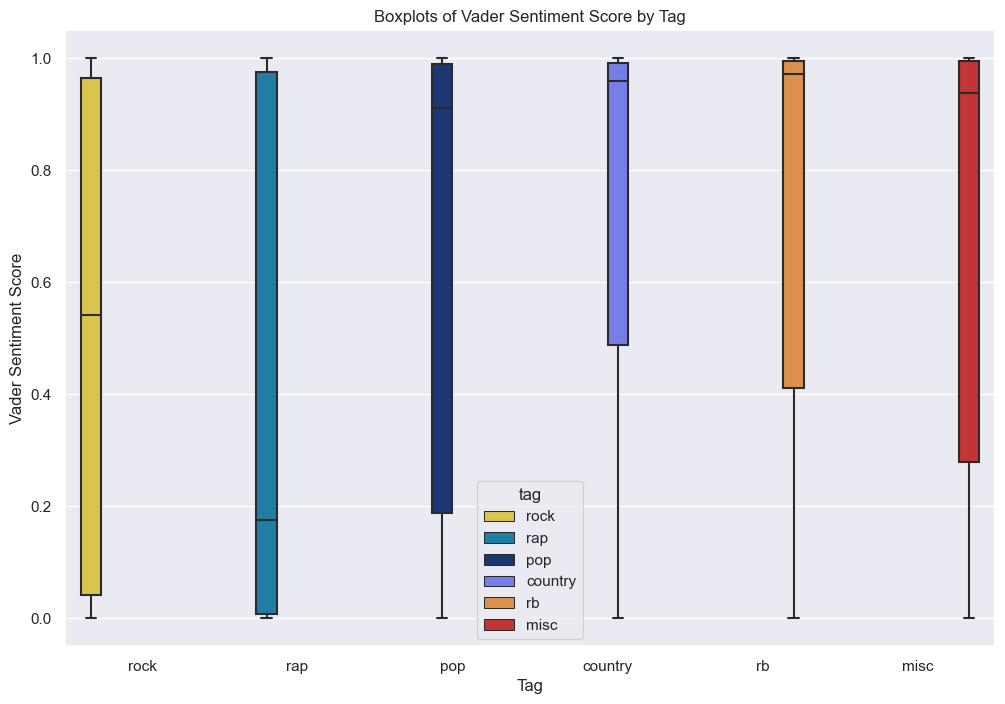

In [64]:
custom_palette = ['#f2d338', '#0a88ba', '#0c3383','#636efa','#f28f38', '#d91e1e']
# Boxplots for analyzing the vader sentiment scores distribution by tag
plt.figure(figsize=(12, 8))
sns.boxplot(x='tag', y='normalized_vader', data=data, hue='tag', palette=custom_palette)  
plt.xlabel("Tag")
plt.ylabel("Vader Sentiment Score")
plt.title("Boxplots of Vader Sentiment Score by Tag")
plt.show()

c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\.conda\envs\TM_Course\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

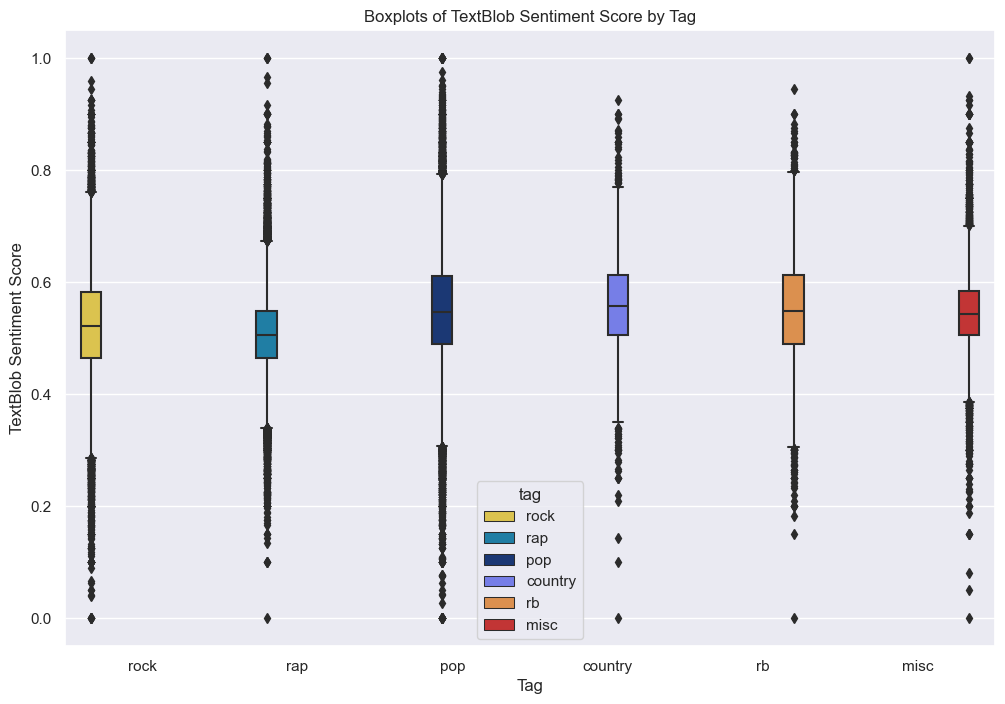

In [65]:
# # Boxplots for analyzing the textblob sentiment scores distribution by tag
plt.figure(figsize=(12, 8))
sns.boxplot(x='tag', y='normalized_textblob', data=data, hue='tag', palette=custom_palette)
plt.xlabel("Tag")
plt.ylabel("TextBlob Sentiment Score")
plt.title("Boxplots of TextBlob Sentiment Score by Tag")
plt.show()

#### 3.1.1. WordClouds per Emotion

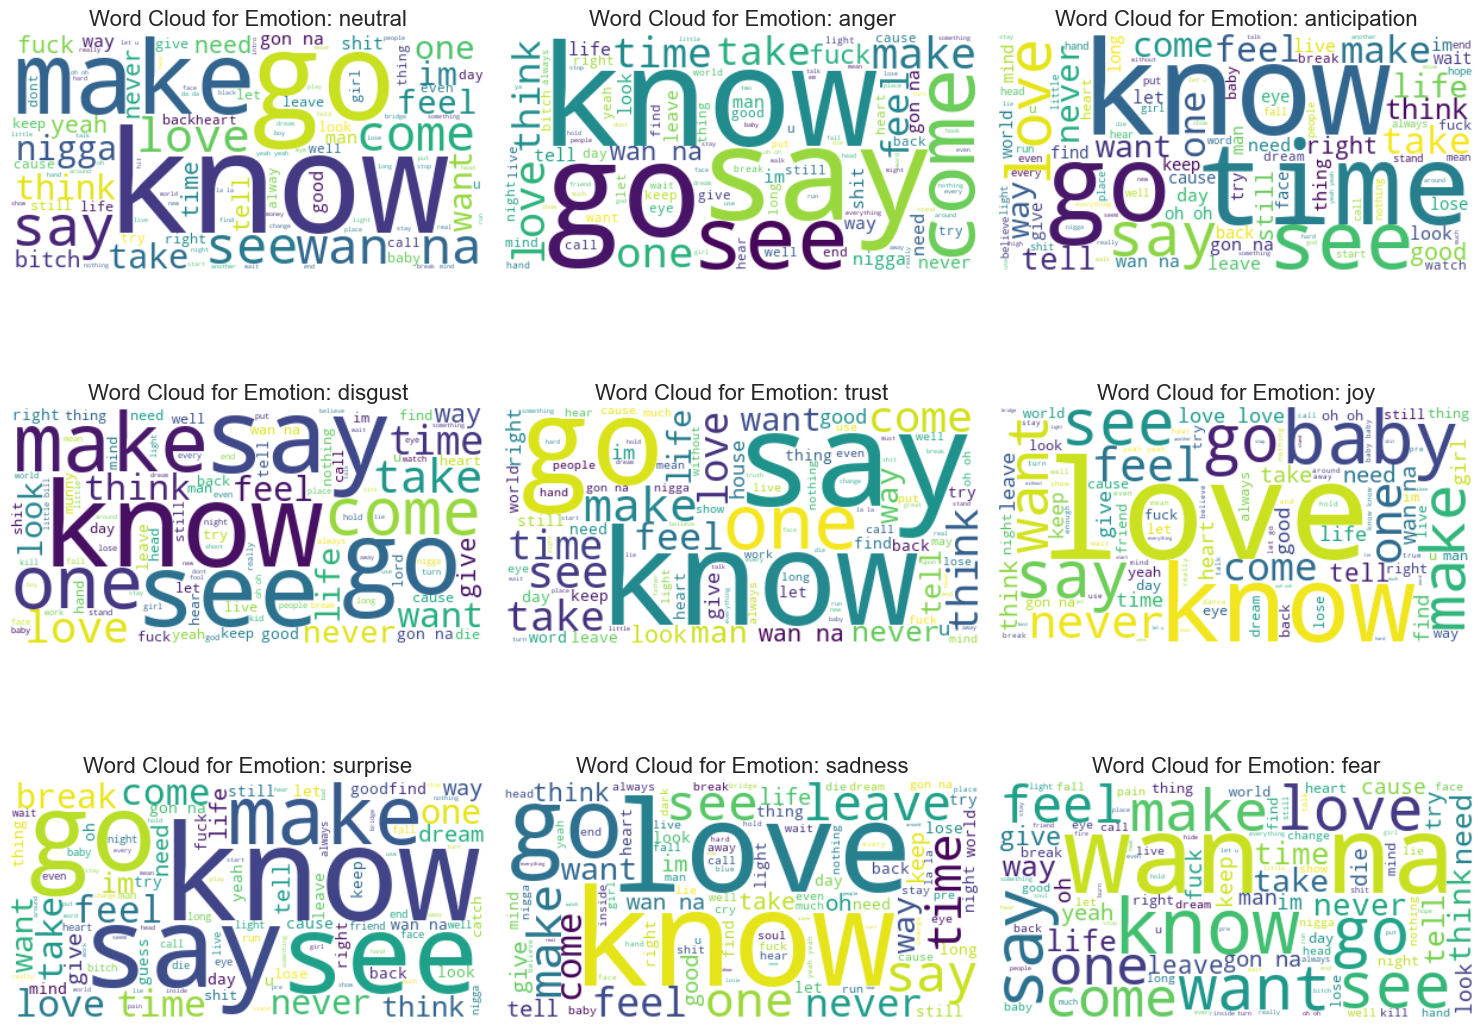

In [38]:
#Displaying the resultant wordcloud
wordcloud_generator_for_emotions(data, emotion_column='emotion', lyrics_column='lyrics', sample_size=1000)

#### 3.1.2. WordClouds per Sentiments

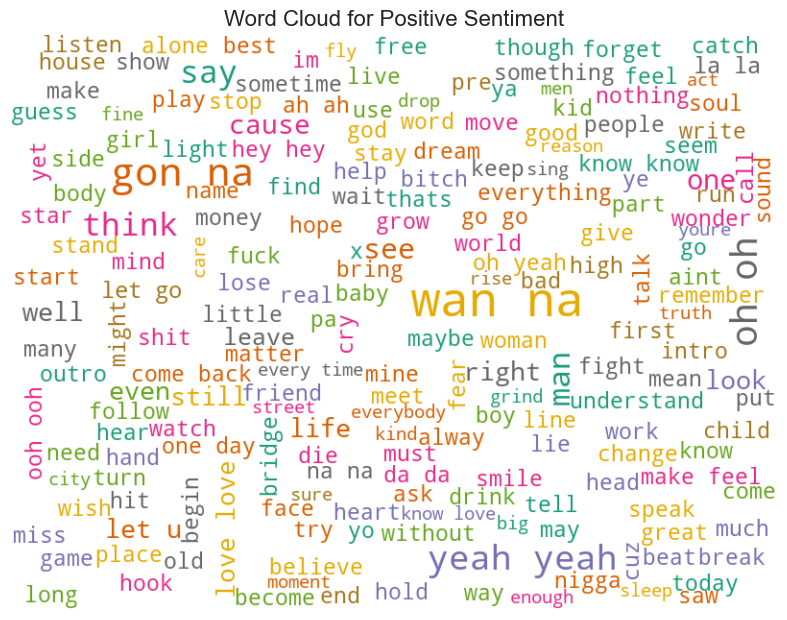

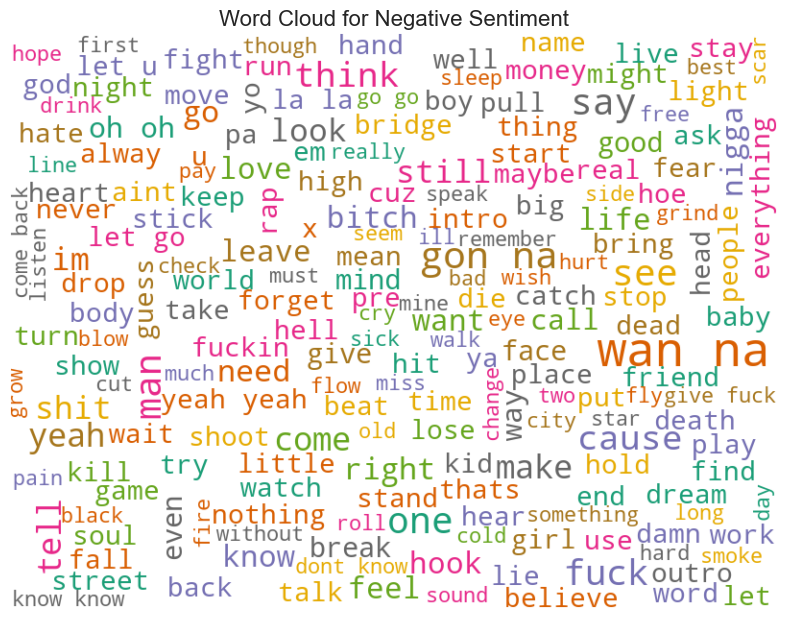

In [18]:
#Displaying the resultant wordcloud
wordcloud_generator_for_sentiments(data, sentiment_column='vader_song', lyrics_column='lyrics')